Deep Learning (MXNET) LSTM


In [91]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from dateutil.parser import parse
import sys
sys.path.append('../')
from mlalgms.statsmodel import calculateHistoricalParameters

In [92]:
anomaly_data = pd.read_csv("../../test_data/timeserials2.csv")


In [93]:
from mlalgms.statsmodel import detectAnomalies
from utils.converterutils import addHeader

In [94]:

idx = anomaly_data.timestamp.values
anomaly_data_ds = [parse(d) for d in idx ]
y = anomaly_data.value.values
df = addHeader (anomaly_data_ds, y)


In [95]:
from mlalgms.deeplearning import L, ctx
from mlalgms.deeplearning import createModel, trainModel, load_and_predict,calculateUpperLowerBound
from mlalgms.deeplearning import evaluate_accuracy,load

In [169]:
model, trainer = createModel(ctx, 1, 100, 0.0005,0.5)
print(model)

Sequential(
  (0): LSTM(None -> 100, TNC, dropout=0.5)
  (1): LSTM(None -> 1, TNC)
)


In [170]:
from mlalgms.evaluator import ts_train_test_split


In [171]:
train_data_selected, test_data_selected  = ts_train_test_split(df, split_ratio=0.75)



In [172]:
train = train_data_selected['y'].as_matrix().astype(np.float32)
test= test_data_selected ['y'].as_matrix().astype(np.float32)
all = df ['y'].as_matrix().astype(np.float32)


In [173]:
batch_size = 128*2
train_loader= load(train,batch_size)
test_loader = load(test, batch_size)

In [174]:
train_mse, test_mse= trainModel(train_loader, test_loader, model,trainer, ctx, 1,1,25,batch_size)
print(train_mse)


 #   upper = calculateThreshold(train_predicted , 2)

[0.005310153821483253, 0.0037576176109723747, 0.003537531350351249, 0.003550552627226959, 0.003506937704514712, 0.0034901649196399376, 0.003472946661834915, 0.0034544217245032387, 0.0034351285721641034, 0.003414477250771597, 0.0033923228475032374, 0.0033683679794194185, 0.0033424192733946265, 0.0033141546446131542, 0.0032832022552611306, 0.0032491412057424895, 0.0032114552668645047, 0.0031695493744337, 0.0031227215343581824, 0.0030701542054885067, 0.003010893868728696, 0.0029438259249824714, 0.0028676292859017845, 0.002780670125503093, 0.0026807051375120254]


In [175]:
print(test_mse)

[0.009175091749057174, 0.0071254323702305555, 0.006977705983445048, 0.00702636712230742, 0.006909196148626506, 0.006877617561258376, 0.006856245920062065, 0.006808373611420393, 0.006768403225578368, 0.006726205465383828, 0.006677258876152337, 0.006626710877753794, 0.006571091478690505, 0.006510428327601403, 0.006444245693273842, 0.006371233728714287, 0.0062906601233407855, 0.0062012148555368185, 0.006101622828282416, 0.005990389559883624, 0.005865864863153547, 0.005726240167859942, 0.005569500965066254, 0.005393315223045647, 0.005194600322283804]


In [176]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

In [177]:


# Plot the training vs test mse
def plot_errors(train_mse, test_mse):
    epochs = range(len(train_mse))
    figsize(16, 7)
    plt.plot(epochs, train_mse, label='Train')
    plt.plot(epochs, test_mse, label='Test')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

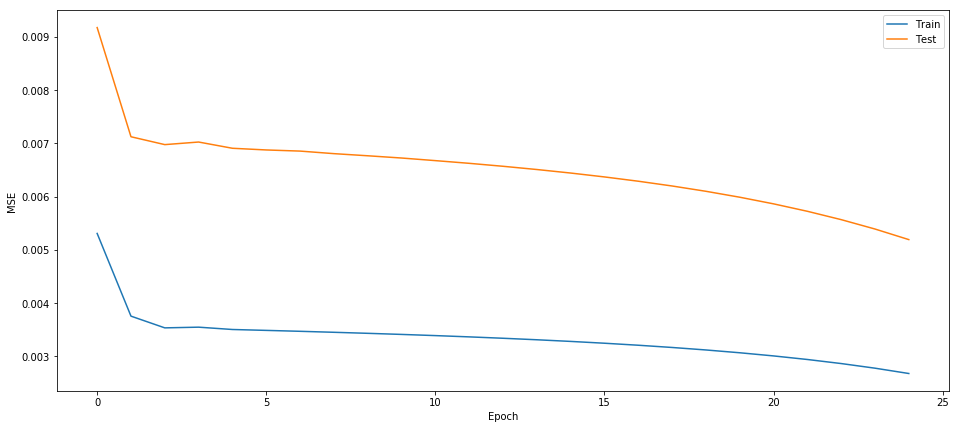

In [178]:
plot_errors(train_mse, test_mse)

In [179]:
tall= load_and_predict(all,L, model, batch_size,1)

print(len(tall))
    

4032


In [180]:
upper, lower = calculateUpperLowerBound(tall , 2)

In [181]:
print(tall, upper)

[4.57936851e-03 1.93030247e-03 6.68008171e-04 ... 1.15164567e-05
 1.10247229e-05 1.07470287e-05] 0.10031226601717358


In [182]:
print(upper,'  , ', lower)

0.10031226601717358   ,  -0.09364033859069174


In [183]:
anomaly = list(map(lambda v: v > upper, tall))

In [184]:
print(len(anomaly))

4032


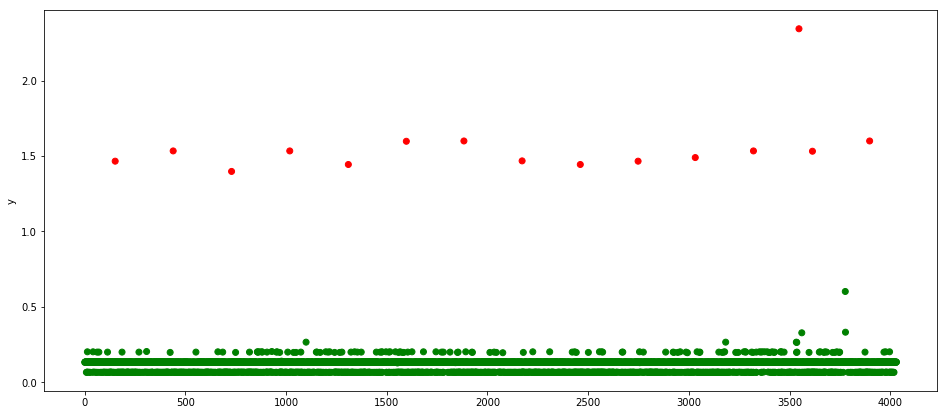

In [185]:
anomaly1 = list(map(lambda v: "red" if v else "green", anomaly))
figsize(16, 7)
plt.scatter(list(range(len(df['y']))),df['y'], c=anomaly1)
plt.ylabel('y')
plt.show()